# Training a neural network model

## 1. Importing necessary libraries

\begin{equation}
    [ \text{Output size} = \left\lfloor \frac{\text{Input size} - \text{Kernel size} + 2 \times \text{Padding}}{\text{Stride}} \right\rfloor + 1 ]
\end{equation}

First, we will import the necessary libraries from python to define our neural network models and other small processes.

In [1]:
import os
from pathlib import Path
import sys

import time
from timeit import default_timer as timer 
import datetime

from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader

import numpy as np

from tqdm import tqdm

import matplotlib.pyplot as plt


Second, we will import a module that defines a class which will help us to upload the atmosphere quantities and the stokes parameters just as it was done in the notebook about [Charging the data](./Charging_the_data.ipynb]).

In [2]:
sys.path.append("../modules")
from data_utils import MURaM

/scratchsan/observatorio/juagudeloo/SpectropolarInvDL/notebooks/../modules/data_utils.py:484: SyntaxWarning: invalid escape sequence '\s'
  df_kappa = pd.read_csv('./csv/kappa.0.dat', sep='\s+', header=None)


## 2. Dataset

### 3. Charge the data

Using the `MURaM` class we will charge the granular-intergranular leveraged data for various filenames.

In [3]:
#filenames to be readed for creating the dataset
filenames = ["080000", "085000", "090000"]

Let's concatenate all the files data to create a unified dataset of atmophere magnitudes with their corresponding stokes parameters spectra.


                ######################## 
                Reading 080000 MuRAM data...
                ######################## 
                      
Charging temperature ...
Charging magnetic field vector...
Charge velocity...

                ######################## 
                Finished!
                ######################## 
                      
Creating atmosphere quantities array...
Saved image to: images/first_experiment/atmosphere/080000_atm_quantities.pdf
Created!
Charging stokes vectors...
Charged!
Loading optical depth stratification...
Loaded from /scratchsan/observatorio/juagudeloo/data/geom_height/logtau_080000.npy
Done!
Mapping to new optical depth stratification...


100%|██████████| 480/480 [00:06<00:00, 68.82it/s]


Loaded!
Modifying magnetic field components to fight azimuth ambiguity...
Quantities modified!
Creating atmosphere quantities array...
Saved image to: images/first_experiment/atmosphere/080000_modified_atm_quantities.pdf
Created!
Degrading...


100%|██████████| 480/480 [00:01<00:00, 246.90it/s]


Scaling the quantities...
Normalizing the Stokes parameters by the continuum...
calculating the continuum...
Scaled!
leveraging...
Done

                ######################## 
                Reading 085000 MuRAM data...
                ######################## 
                      
Charging temperature ...
Charging magnetic field vector...
Charge velocity...

                ######################## 
                Finished!
                ######################## 
                      
Creating atmosphere quantities array...
Saved image to: images/first_experiment/atmosphere/085000_atm_quantities.pdf
Created!
Charging stokes vectors...
Charged!
Loading optical depth stratification...
Loaded from /scratchsan/observatorio/juagudeloo/data/geom_height/logtau_085000.npy
Done!
Mapping to new optical depth stratification...


100%|██████████| 480/480 [00:07<00:00, 67.95it/s]


Loaded!
Modifying magnetic field components to fight azimuth ambiguity...
Quantities modified!
Creating atmosphere quantities array...
Saved image to: images/first_experiment/atmosphere/085000_modified_atm_quantities.pdf
Created!
Degrading...


100%|██████████| 480/480 [00:01<00:00, 245.74it/s]


Scaling the quantities...
Normalizing the Stokes parameters by the continuum...
calculating the continuum...
Scaled!
leveraging...
Done

                ######################## 
                Reading 090000 MuRAM data...
                ######################## 
                      
Charging temperature ...
Charging magnetic field vector...
Charge velocity...

                ######################## 
                Finished!
                ######################## 
                      
Creating atmosphere quantities array...
Saved image to: images/first_experiment/atmosphere/090000_atm_quantities.pdf
Created!
Charging stokes vectors...
Charged!
Loading optical depth stratification...
Loaded from /scratchsan/observatorio/juagudeloo/data/geom_height/logtau_090000.npy
Done!
Mapping to new optical depth stratification...


100%|██████████| 480/480 [00:06<00:00, 68.94it/s]


Loaded!
Modifying magnetic field components to fight azimuth ambiguity...
Quantities modified!
Creating atmosphere quantities array...
Saved image to: images/first_experiment/atmosphere/090000_modified_atm_quantities.pdf
Created!
Degrading...


100%|██████████| 480/480 [00:01<00:00, 248.21it/s]


Scaling the quantities...
Normalizing the Stokes parameters by the continuum...
calculating the continuum...
Scaled!
leveraging...
Done


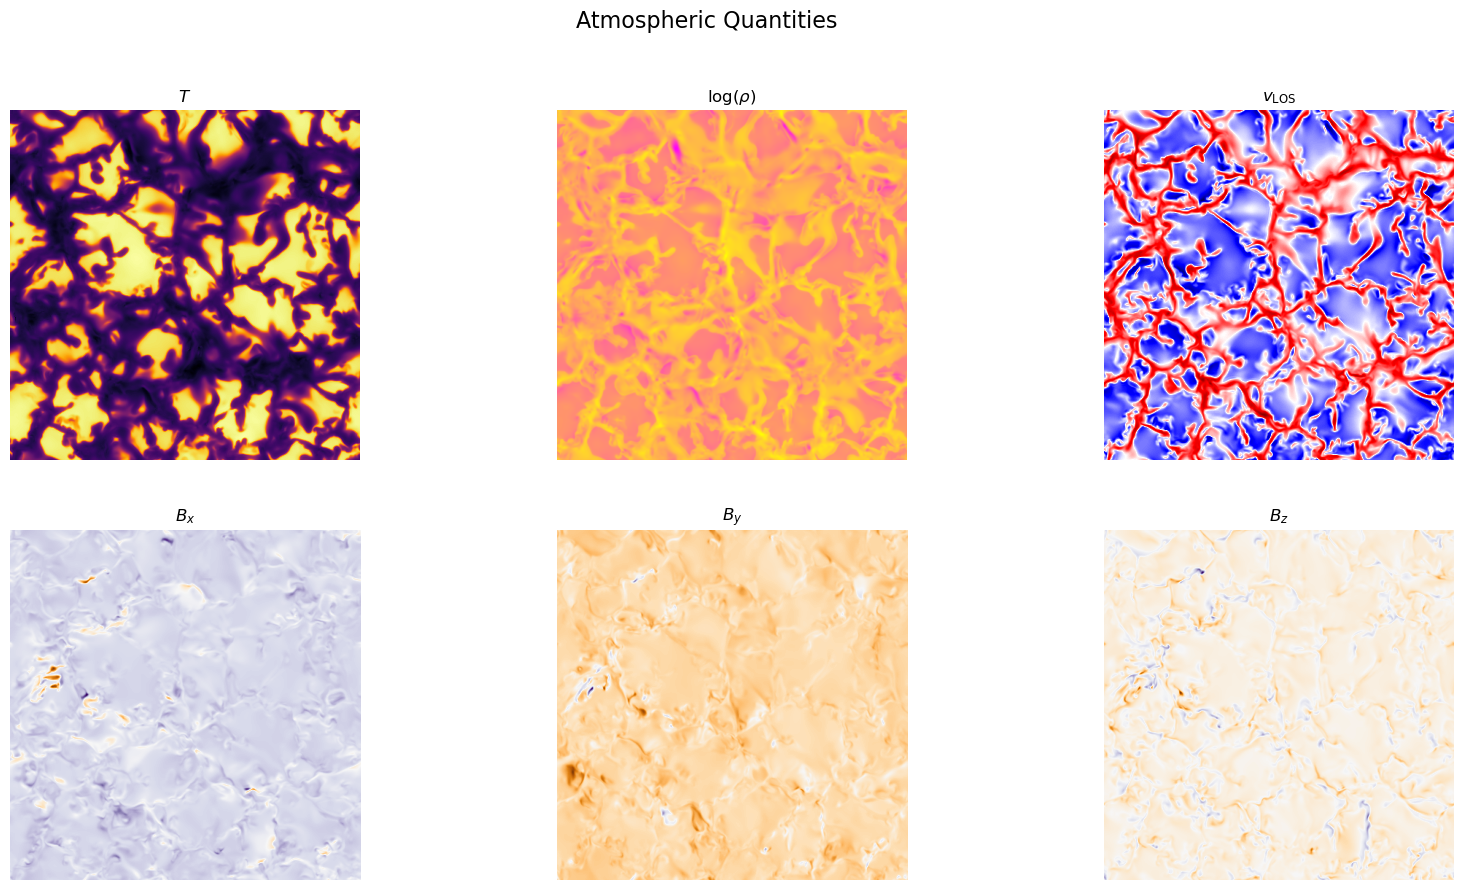

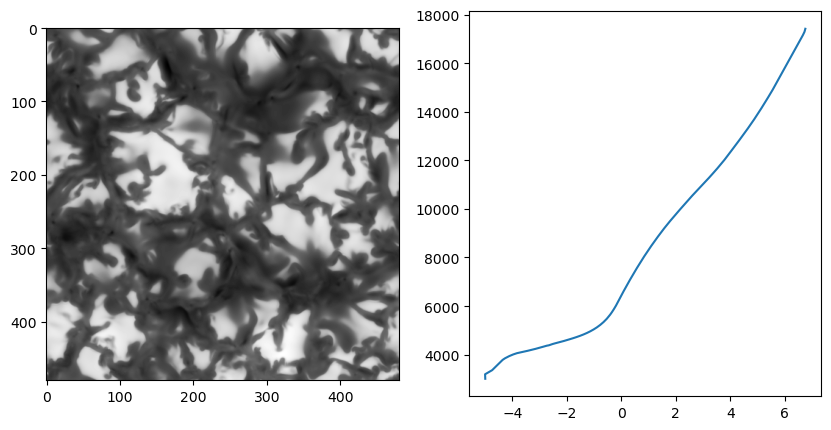

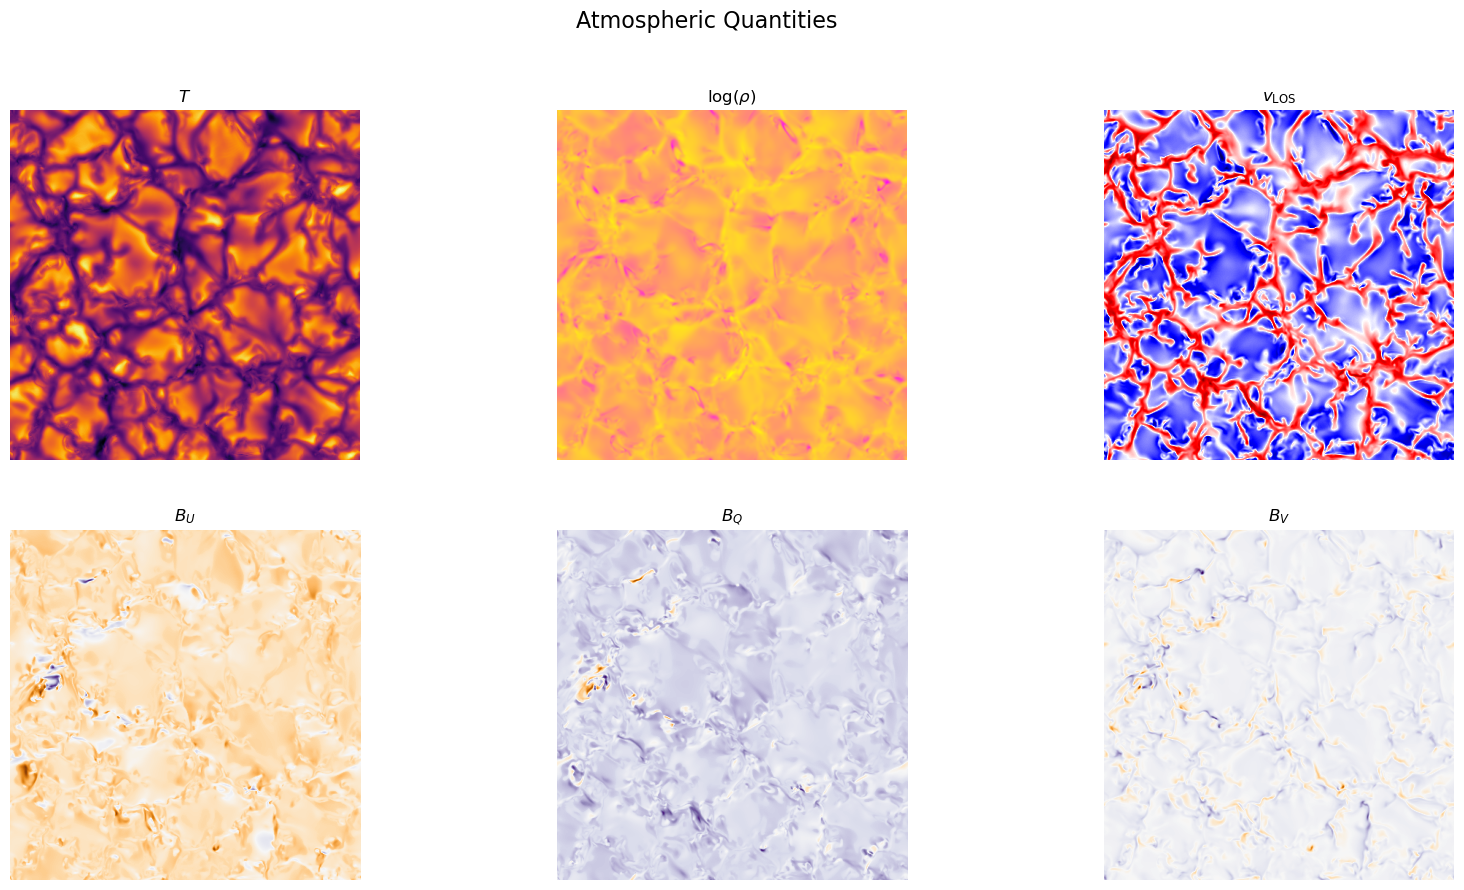

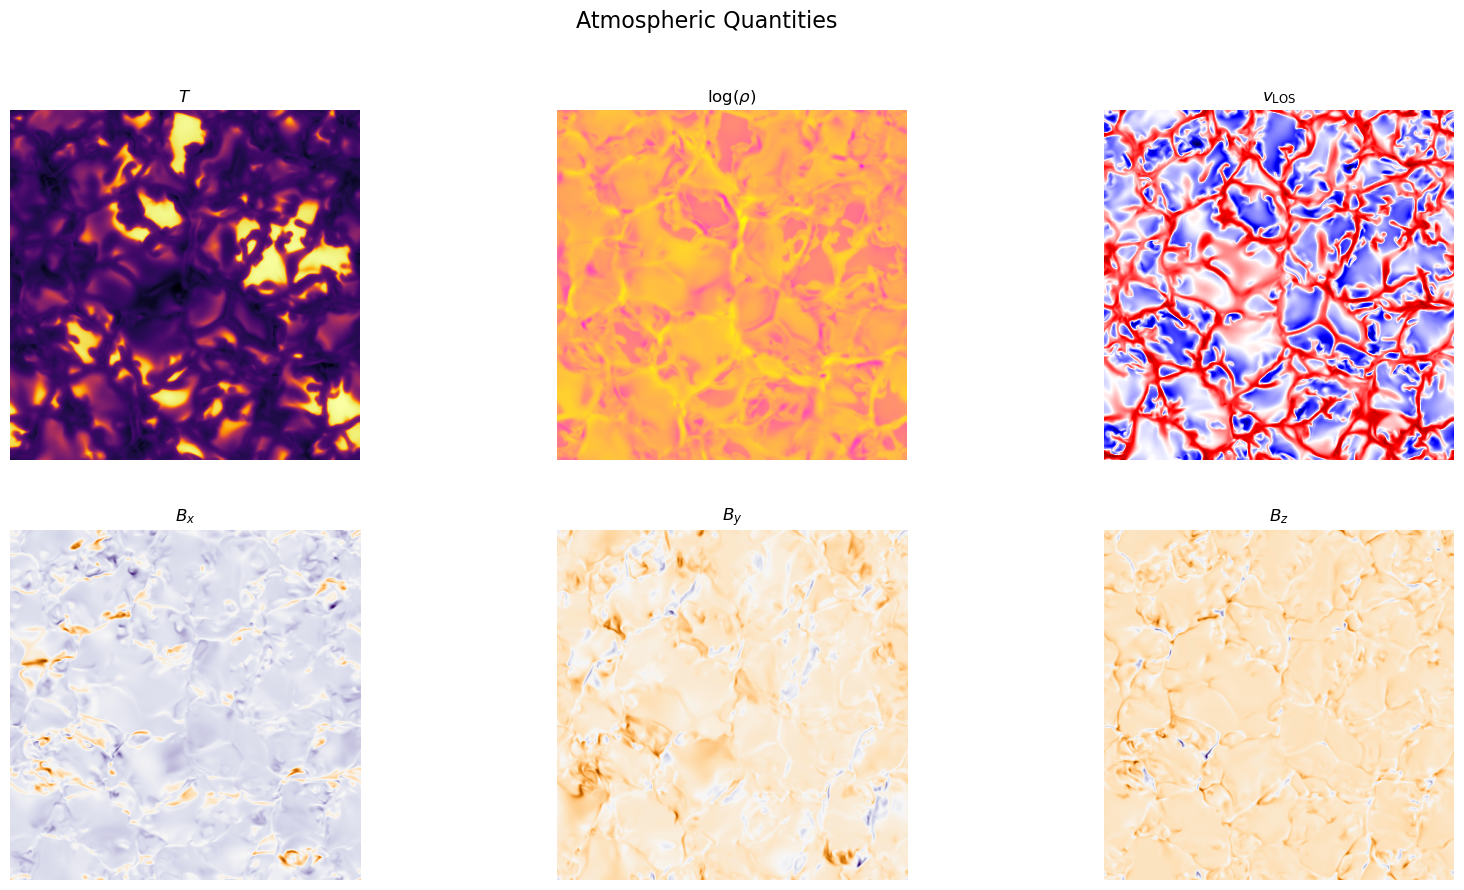

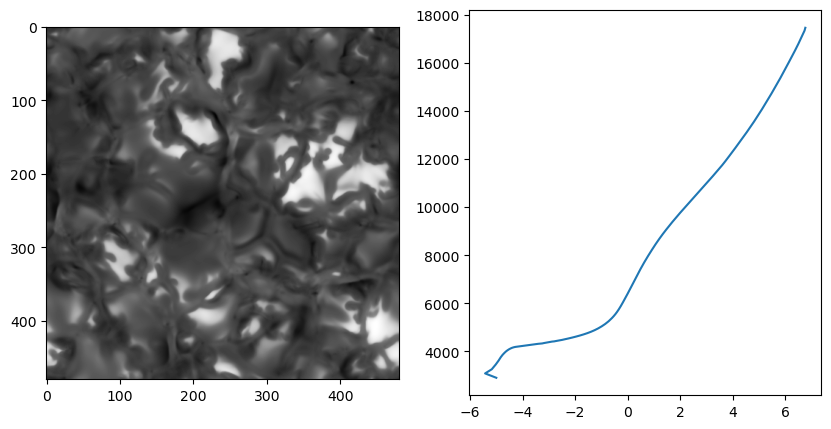

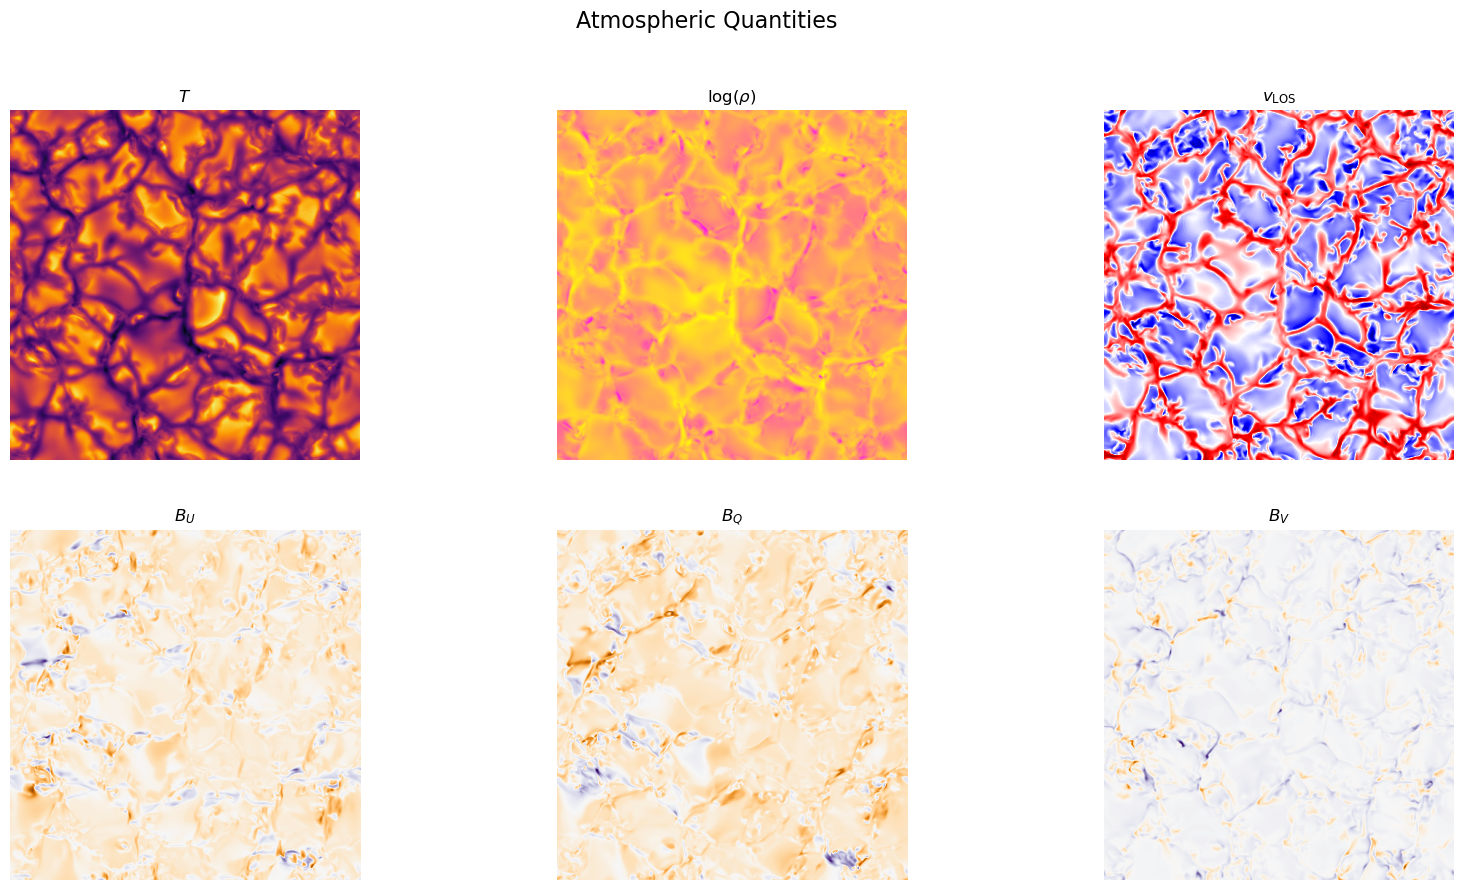

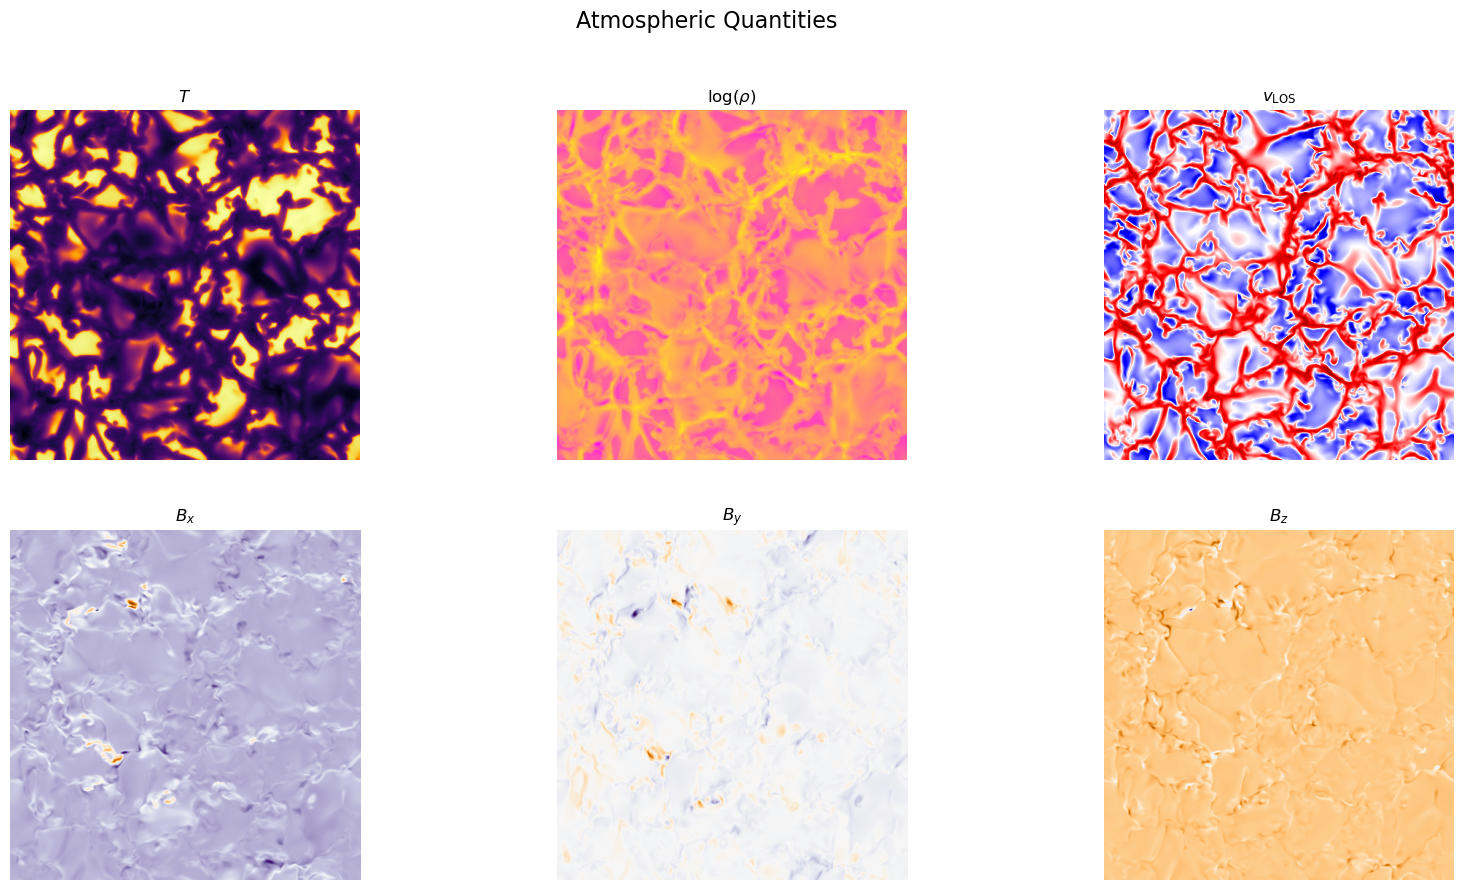

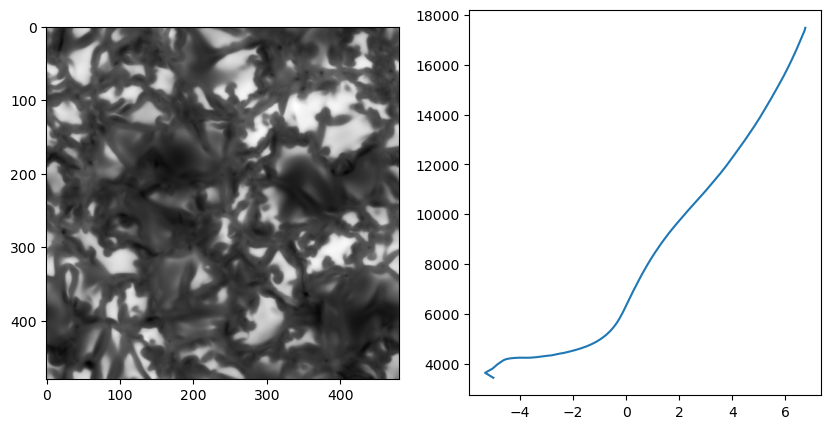

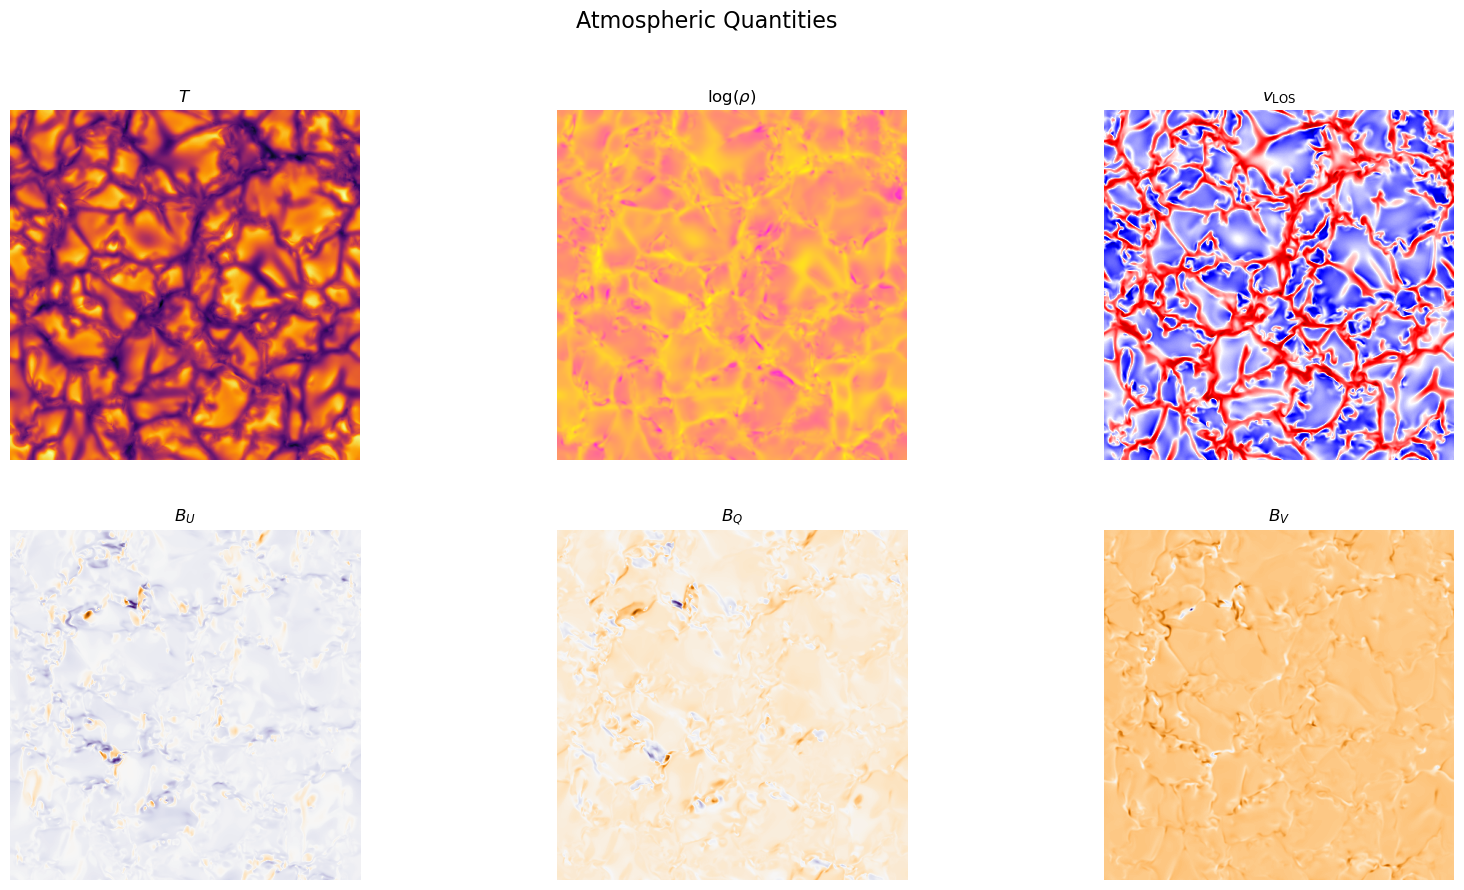

In [6]:
#Arrays for saving the whole dataset
atm_data = []
stokes_data = []

n_spectral_points = 36
new_logtau = np.linspace(-2.5, 0, 20)
stokes_weights = [1,10,10,10]

for fln in filenames:
    #Creation of the MURaM object for each filename for charging the data.
    muram = MURaM(filename=fln)
    muram.charge_quantities()
    muram.optical_depth_stratification(new_logtau=new_logtau)
    muram.modified_components()
    muram.degrade_spec_resol(new_points=n_spectral_points)
    muram.scale_quantities(stokes_weigths=stokes_weights)
    muram.gran_intergran_balance()

    atm_data.append(muram.atm_quant)
    stokes_data.append(muram.stokes)

atm_data = np.concatenate(atm_data, axis=0)
stokes_data = np.concatenate(stokes_data, axis=0)
    

In [7]:
atm_data.shape, stokes_data.shape

((632010, 20, 6), (632010, 36, 4))

### 2.2 Training and testing sets

Once we have the data uploaded, we may need to separate it between training and testing sets for applying the data set to the neural network learning process. The train set will have a 70% size of the whole dataset while the test set will have a 30%.

In [6]:
in_train, in_test, out_train, out_test = train_test_split(stokes_data, atm_data, test_size=0.33, random_state=42)

In [7]:
print("in_train shape:", in_train.shape)
print("out_train shape:", out_train.shape)
print("in_test shape:", in_test.shape)
print("out_test shape:", out_test.shape)

in_train shape: (423446, 36, 4)
out_train shape: (423446, 20, 6)
in_test shape: (208564, 36, 4)
out_test shape: (208564, 20, 6)


Having the test and train sets defined, let's charge them inside pytorch dataloaders for the training of the model.

In [8]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Tensors stored in: {device}")

Tensors stored in: cpu


/homes/observatorio/juagudeloo/.conda/envs/pytorch_jupyter/lib/python3.12/site-packages/torch/cuda/__init__.py:129: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at /opt/conda/conda-bld/pytorch_1729647378361/work/c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [9]:
#Converting the test and train datasets to tensors
in_train = torch.from_numpy(in_train).to(device)
in_test = torch.from_numpy(in_test).to(device)
out_train = torch.from_numpy(out_train).to(device)
out_test = torch.from_numpy(out_test).to(device)

In [10]:
print("in_train shape:", in_train.size())
print("out_train shape:", out_train.size())
print("in_test shape:", in_test.size())
print("out_test shape:", out_test.size())

in_train shape: torch.Size([423446, 36, 4])
out_train shape: torch.Size([423446, 20, 6])
in_test shape: torch.Size([208564, 36, 4])
out_test shape: torch.Size([208564, 20, 6])


Because the output of the neural network model we are going to use is linear, it is necessary to flatten the last two axis of the out datasets corresponding to the atmosphere magnitudes.

In [11]:
#Flattening of the output external axes
out_train = torch.reshape(out_train, (out_train.size()[0], out_train.size()[1]*out_train.size()[2]))
out_test = torch.reshape(out_test, (out_test.size()[0], out_test.size()[1]*out_test.size()[2]))

In [12]:
print("in_train shape:", in_train.size())
print("out_train shape:", out_train.size())
print("in_test shape:", in_test.size())
print("out_test shape:", out_test.size())

in_train shape: torch.Size([423446, 36, 4])
out_train shape: torch.Size([423446, 120])
in_test shape: torch.Size([208564, 36, 4])
out_test shape: torch.Size([208564, 120])


Finally, having both datasets converted to tensors, let's save them in their corresponding pytorch dataloaders. Here we will define the batch size hyperparameter for the training process.

In [14]:
#Batch size
batch_size = 80

#Train and test datasets
train_dataset = TensorDataset(in_train.to(device), out_train.to(device))
test_dataset = TensorDataset(in_test.to(device), out_test.to(device))

#Train and test dataloaders
train_dataloader = DataLoader(train_dataset,
        batch_size=batch_size, # how many samples per batch? 
        shuffle=True # shuffle data every epoch?
)

test_dataloader = DataLoader(test_dataset,
    batch_size=batch_size,
    shuffle=False # don't necessarily have to shuffle the testing data
)    

print(f"Length of train dataloader: {len(train_dataloader)} batches of {batch_size}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {batch_size}")
train_features_batch, train_labels_batch = next(iter(train_dataloader))
print(f"""
Shape of each batch input and output:
train input batch shape: {train_features_batch.shape}, 
train output batch shape: {train_labels_batch.shape}
        """ )

Length of train dataloader: 5294 batches of 80
Length of test dataloader: 2608 batches of 80

Shape of each batch input and output:
train input batch shape: torch.Size([80, 36, 4]), 
train output batch shape: torch.Size([80, 120])
        


## 3. Neural network model

Now that we have the datasets defined, let's create our neural network model. 

### 3.1 Model creation

First let's use a very simple convolutional 1D neural network arquitecture with a linear output.

In [18]:
class SimpleModel(nn.Module):
    def __init__(self, in_shape, out_shape, hidden_units):
        super().__init__()
        padding = 1
        self.simple_conv = nn.Sequential(
        nn.Conv1d(in_channels=in_shape, out_channels=72, kernel_size = 2, stride=1, padding=padding),
        nn.ReLU(),
        nn.Flatten(),
        nn.Dropout(p=0.5, inplace=False),
        nn.Linear(in_features = 360, out_features = out_shape)
        )
    def forward(self, x):
        return self.simple_conv(x)

model = SimpleModel(36,6*20,hidden_units=4096).float()

It's important that the datasets and the model are both in the same device for performind the training.

In [22]:
print("\nThe model will be runned in:", device)
model.to(device)


The model will be runned in: cpu


SimpleModel(
  (simple_conv): Sequential(
    (0): Conv1d(36, 72, kernel_size=(2,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): Flatten(start_dim=1, end_dim=-1)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=360, out_features=120, bias=True)
  )
)

Define the model loss function and optimizer, along with the learning rate and epochs hyperparameters.

In [52]:
#Epochs
epochs = 20

#Learning rate
lr = 1e-5

#Loss function
loss_fn = nn.MSELoss() # this is also called "criterion"/"cost function" in some places

#Optimizer
optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)

We must write down the path for the model to save the results of the training along with the trained weights.

In [53]:
results_out = "Results/"
if not os.path.exists(results_out):
    os.mkdir(results_out)
    
#Training folder for the specific hyperparameters
pth_out = results_out+f"{epochs}E_"+f"{lr}lr/"
if not os.path.exists(pth_out):
    os.mkdir(pth_out)
#Create model save path
MODEL_PATH = Path(pth_out+"model_weights/")
MODEL_PATH.mkdir(parents=True, exist_ok=True)
MODEL_NAME = "inversion_"+str(epochs)+"E"+str(lr)+"lr"+".pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME
#Charge the weights in case there have been some training before
if MODEL_SAVE_PATH.exists():
    model.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

### 3.2 Training the model

We have everything settled! Let's code the training process. First let's define functions for the training and testing.

In [54]:
def train_step(model: nn.Module, train_dataloader: DataLoader, loss_fn, optimizer, device):
    """
    Function that performs the training step over all the batches in the train dataloader.
    
    Args:
        model(nn.Module): Model to be trained.
        train_dataloader(torch.utils.data.Dataloader): Dataloader of the training dataset.
        loss_fn: Loss function for the training process.
        optimizer: Optimizer function for the training process.
        device: Agnostic device defined por allocating the data and the model.
    Returns:
        None
    """
    # Add a loop to loop through training batches
    train_loss = 0

    for batch, (X, y) in enumerate(train_dataloader):
        model.train() 
        # 1. Forward pass
        X, y = X.to(device), y.to(device)
        y_pred = model.double()(X.double())

        # 2. Calculate loss (per batch)
        loss = loss_fn(y_pred.double(), y.double())
        train_loss += loss # accumulatively add up the loss per epoch 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Print out how many samples have been seen
        if batch % 400 == 0:
            print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples")

    # Divide total train loss by length of train dataloader (average loss per batch per epoch)
    train_loss /= len(train_dataloader)

    return train_loss

def test_step(model: nn.Module, test_dataloader: DataLoader, loss_fn):
    """
    Function that performs the testing step over the testin dataloader.
    
    Args:
        model(nn.Module): Model to be tested.
        test_dataloader(torch.utils.data.Dataloader): Dataloader of the testing dataset.
        loss_fn: Loss function for the testing the model results.
    Returns:
        None
    """
    # Setup variables for accumulatively adding up loss and accuracy 
    test_loss, test_acc = 0, 0 
    model.eval()
    with torch.inference_mode():
        for X, y in test_dataloader:
            # 1. Forward pass
            test_pred = model(X)
        
            # 2. Calculate loss (accumatively)
            test_loss += loss_fn(test_pred, y) # accumulatively add up the loss per epoch

        # Calculations on test metrics need to happen inside torch.inference_mode()

        # Divide total test loss by length of test dataloader (per batch)
        test_loss /= len(test_dataloader)
    
    return test_loss

def print_train_time(start: float, end: float, device: torch.device = None):
    """Prints difference between start and end time.

    Args:
        start (float): Start time of computation (preferred in timeit format). 
        end (float): End time of computation.
        device ([type], optional): Device that compute is running on. Defaults to None.

    Returns:
        float: time between start and end in seconds (higher is longer).
    """
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

Let's train!

In [55]:
train_loss_history = np.zeros((epochs,))
test_loss_history = np.zeros((epochs,))

total_train_time_model = 0
# Set timers
train_time_start_on_cpu = timer()
start = time.time()
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n-------")
    ### Training
    train_loss = train_step(model, train_dataloader, loss_fn, optimizer, device)
    train_loss_history[epoch] = train_loss
    
    ### Testing)
    test_loss = test_step(model, test_dataloader, loss_fn)
    test_loss_history[epoch] = test_loss
    
    ## Print out what's happening
    print(f"\nTrain loss: {train_loss:.5f} | Test loss: {test_loss:.5f}")    

    # Calculate training time      
    train_time_end_on_cpu = timer()
    total_train_time_model += print_train_time(start=train_time_start_on_cpu, 
                                            end=train_time_end_on_cpu,
                                            device=str(next(model.parameters()).device))

    # the model state dict after training
    print(f"Saving model to: {MODEL_SAVE_PATH}")
    torch.save(obj=model.state_dict(), # only saving the state_dict() only saves the models learned parameters
            f=MODEL_SAVE_PATH)
    
metrics_out = pth_out+"loss_metrics/"
if not os.path.exists(metrics_out):
    os.mkdir(metrics_out)
    
train_loss_history_path = metrics_out+"train_loss_history"+str(epochs)+"E"+str(lr)+"lr"+".npy"
test_loss_history_path = metrics_out+"test_loss_history"+str(epochs)+"E"+str(lr)+"lr"+".npy"

np.save(train_loss_history_path, train_loss_history)
np.save(test_loss_history_path, test_loss_history)

runtime = time.time()-start
with open(metrics_out+"runtime.txt", "w") as f:
    f.write(str(datetime.timedelta(seconds=runtime)))


  0%|                                                                                          | 0/20 [00:00<?, ?it/s]

Epoch: 0
-------
Looked at 0/423446 samples
Looked at 32000/423446 samples
Looked at 64000/423446 samples
Looked at 96000/423446 samples
Looked at 128000/423446 samples
Looked at 160000/423446 samples
Looked at 192000/423446 samples
Looked at 224000/423446 samples
Looked at 256000/423446 samples
Looked at 288000/423446 samples
Looked at 320000/423446 samples
Looked at 352000/423446 samples
Looked at 384000/423446 samples
Looked at 416000/423446 samples


  5%|████                                                                              | 1/20 [00:22<07:16, 22.95s/it]


Train loss: 0.00142 | Test loss: 0.00125
Train time on cpu: 22.947 seconds
Saving model to: Results/20E_1e-05lr/model_weights/inversion_20E1e-05lr.pth
Epoch: 1
-------
Looked at 0/423446 samples
Looked at 32000/423446 samples
Looked at 64000/423446 samples
Looked at 96000/423446 samples
Looked at 128000/423446 samples
Looked at 160000/423446 samples
Looked at 192000/423446 samples
Looked at 224000/423446 samples
Looked at 256000/423446 samples
Looked at 288000/423446 samples
Looked at 320000/423446 samples
Looked at 352000/423446 samples
Looked at 384000/423446 samples
Looked at 416000/423446 samples


 10%|████████▏                                                                         | 2/20 [00:43<06:23, 21.31s/it]


Train loss: 0.00141 | Test loss: 0.00125
Train time on cpu: 43.115 seconds
Saving model to: Results/20E_1e-05lr/model_weights/inversion_20E1e-05lr.pth
Epoch: 2
-------
Looked at 0/423446 samples
Looked at 32000/423446 samples
Looked at 64000/423446 samples
Looked at 96000/423446 samples
Looked at 128000/423446 samples
Looked at 160000/423446 samples
Looked at 192000/423446 samples
Looked at 224000/423446 samples
Looked at 256000/423446 samples
Looked at 288000/423446 samples
Looked at 320000/423446 samples
Looked at 352000/423446 samples
Looked at 384000/423446 samples
Looked at 416000/423446 samples


 15%|████████████▎                                                                     | 3/20 [01:03<05:54, 20.83s/it]


Train loss: 0.00141 | Test loss: 0.00124
Train time on cpu: 63.372 seconds
Saving model to: Results/20E_1e-05lr/model_weights/inversion_20E1e-05lr.pth
Epoch: 3
-------
Looked at 0/423446 samples
Looked at 32000/423446 samples
Looked at 64000/423446 samples
Looked at 96000/423446 samples
Looked at 128000/423446 samples
Looked at 160000/423446 samples
Looked at 192000/423446 samples
Looked at 224000/423446 samples
Looked at 256000/423446 samples
Looked at 288000/423446 samples
Looked at 320000/423446 samples
Looked at 352000/423446 samples
Looked at 384000/423446 samples
Looked at 416000/423446 samples


 20%|████████████████▍                                                                 | 4/20 [01:23<05:29, 20.62s/it]


Train loss: 0.00141 | Test loss: 0.00124
Train time on cpu: 83.669 seconds
Saving model to: Results/20E_1e-05lr/model_weights/inversion_20E1e-05lr.pth
Epoch: 4
-------
Looked at 0/423446 samples
Looked at 32000/423446 samples
Looked at 64000/423446 samples
Looked at 96000/423446 samples
Looked at 128000/423446 samples
Looked at 160000/423446 samples
Looked at 192000/423446 samples
Looked at 224000/423446 samples
Looked at 256000/423446 samples
Looked at 288000/423446 samples
Looked at 320000/423446 samples
Looked at 352000/423446 samples
Looked at 384000/423446 samples
Looked at 416000/423446 samples


 25%|████████████████████▌                                                             | 5/20 [01:43<05:07, 20.48s/it]


Train loss: 0.00141 | Test loss: 0.00125
Train time on cpu: 103.901 seconds
Saving model to: Results/20E_1e-05lr/model_weights/inversion_20E1e-05lr.pth
Epoch: 5
-------
Looked at 0/423446 samples
Looked at 32000/423446 samples
Looked at 64000/423446 samples
Looked at 96000/423446 samples
Looked at 128000/423446 samples
Looked at 160000/423446 samples
Looked at 192000/423446 samples
Looked at 224000/423446 samples
Looked at 256000/423446 samples
Looked at 288000/423446 samples
Looked at 320000/423446 samples
Looked at 352000/423446 samples
Looked at 384000/423446 samples
Looked at 416000/423446 samples


 30%|████████████████████████▌                                                         | 6/20 [02:08<05:05, 21.80s/it]


Train loss: 0.00141 | Test loss: 0.00124
Train time on cpu: 128.254 seconds
Saving model to: Results/20E_1e-05lr/model_weights/inversion_20E1e-05lr.pth
Epoch: 6
-------
Looked at 0/423446 samples
Looked at 32000/423446 samples
Looked at 64000/423446 samples
Looked at 96000/423446 samples
Looked at 128000/423446 samples
Looked at 160000/423446 samples
Looked at 192000/423446 samples
Looked at 224000/423446 samples
Looked at 256000/423446 samples
Looked at 288000/423446 samples
Looked at 320000/423446 samples
Looked at 352000/423446 samples
Looked at 384000/423446 samples
Looked at 416000/423446 samples


 35%|████████████████████████████▋                                                     | 7/20 [02:29<04:41, 21.65s/it]


Train loss: 0.00141 | Test loss: 0.00125
Train time on cpu: 149.603 seconds
Saving model to: Results/20E_1e-05lr/model_weights/inversion_20E1e-05lr.pth
Epoch: 7
-------
Looked at 0/423446 samples
Looked at 32000/423446 samples
Looked at 64000/423446 samples
Looked at 96000/423446 samples
Looked at 128000/423446 samples
Looked at 160000/423446 samples
Looked at 192000/423446 samples
Looked at 224000/423446 samples
Looked at 256000/423446 samples
Looked at 288000/423446 samples
Looked at 320000/423446 samples
Looked at 352000/423446 samples
Looked at 384000/423446 samples
Looked at 416000/423446 samples


 40%|████████████████████████████████▊                                                 | 8/20 [02:50<04:18, 21.54s/it]


Train loss: 0.00141 | Test loss: 0.00124
Train time on cpu: 170.898 seconds
Saving model to: Results/20E_1e-05lr/model_weights/inversion_20E1e-05lr.pth
Epoch: 8
-------
Looked at 0/423446 samples
Looked at 32000/423446 samples
Looked at 64000/423446 samples
Looked at 96000/423446 samples
Looked at 128000/423446 samples
Looked at 160000/423446 samples
Looked at 192000/423446 samples
Looked at 224000/423446 samples
Looked at 256000/423446 samples
Looked at 288000/423446 samples
Looked at 320000/423446 samples
Looked at 352000/423446 samples
Looked at 384000/423446 samples
Looked at 416000/423446 samples


 45%|████████████████████████████████████▉                                             | 9/20 [03:11<03:55, 21.40s/it]


Train loss: 0.00141 | Test loss: 0.00125
Train time on cpu: 191.994 seconds
Saving model to: Results/20E_1e-05lr/model_weights/inversion_20E1e-05lr.pth
Epoch: 9
-------
Looked at 0/423446 samples
Looked at 32000/423446 samples
Looked at 64000/423446 samples
Looked at 96000/423446 samples
Looked at 128000/423446 samples
Looked at 160000/423446 samples
Looked at 192000/423446 samples
Looked at 224000/423446 samples
Looked at 256000/423446 samples
Looked at 288000/423446 samples
Looked at 320000/423446 samples
Looked at 352000/423446 samples
Looked at 384000/423446 samples
Looked at 416000/423446 samples


 50%|████████████████████████████████████████▌                                        | 10/20 [03:35<03:40, 22.07s/it]


Train loss: 0.00141 | Test loss: 0.00124
Train time on cpu: 215.580 seconds
Saving model to: Results/20E_1e-05lr/model_weights/inversion_20E1e-05lr.pth
Epoch: 10
-------
Looked at 0/423446 samples
Looked at 32000/423446 samples
Looked at 64000/423446 samples
Looked at 96000/423446 samples
Looked at 128000/423446 samples
Looked at 160000/423446 samples
Looked at 192000/423446 samples
Looked at 224000/423446 samples
Looked at 256000/423446 samples
Looked at 288000/423446 samples
Looked at 320000/423446 samples
Looked at 352000/423446 samples
Looked at 384000/423446 samples
Looked at 416000/423446 samples


 55%|████████████████████████████████████████████▌                                    | 11/20 [03:56<03:16, 21.81s/it]


Train loss: 0.00141 | Test loss: 0.00125
Train time on cpu: 236.781 seconds
Saving model to: Results/20E_1e-05lr/model_weights/inversion_20E1e-05lr.pth
Epoch: 11
-------
Looked at 0/423446 samples
Looked at 32000/423446 samples
Looked at 64000/423446 samples
Looked at 96000/423446 samples
Looked at 128000/423446 samples
Looked at 160000/423446 samples
Looked at 192000/423446 samples
Looked at 224000/423446 samples
Looked at 256000/423446 samples
Looked at 288000/423446 samples
Looked at 320000/423446 samples
Looked at 352000/423446 samples
Looked at 384000/423446 samples
Looked at 416000/423446 samples


 60%|████████████████████████████████████████████████▌                                | 12/20 [04:18<02:55, 21.93s/it]


Train loss: 0.00141 | Test loss: 0.00124
Train time on cpu: 258.989 seconds
Saving model to: Results/20E_1e-05lr/model_weights/inversion_20E1e-05lr.pth
Epoch: 12
-------
Looked at 0/423446 samples
Looked at 32000/423446 samples
Looked at 64000/423446 samples
Looked at 96000/423446 samples
Looked at 128000/423446 samples
Looked at 160000/423446 samples
Looked at 192000/423446 samples
Looked at 224000/423446 samples
Looked at 256000/423446 samples
Looked at 288000/423446 samples
Looked at 320000/423446 samples
Looked at 352000/423446 samples
Looked at 384000/423446 samples
Looked at 416000/423446 samples


 65%|████████████████████████████████████████████████████▋                            | 13/20 [04:40<02:32, 21.72s/it]


Train loss: 0.00141 | Test loss: 0.00124
Train time on cpu: 280.217 seconds
Saving model to: Results/20E_1e-05lr/model_weights/inversion_20E1e-05lr.pth
Epoch: 13
-------
Looked at 0/423446 samples
Looked at 32000/423446 samples
Looked at 64000/423446 samples
Looked at 96000/423446 samples
Looked at 128000/423446 samples
Looked at 160000/423446 samples
Looked at 192000/423446 samples
Looked at 224000/423446 samples
Looked at 256000/423446 samples
Looked at 288000/423446 samples
Looked at 320000/423446 samples
Looked at 352000/423446 samples
Looked at 384000/423446 samples
Looked at 416000/423446 samples


 70%|████████████████████████████████████████████████████████▋                        | 14/20 [05:01<02:09, 21.56s/it]


Train loss: 0.00141 | Test loss: 0.00124
Train time on cpu: 301.402 seconds
Saving model to: Results/20E_1e-05lr/model_weights/inversion_20E1e-05lr.pth
Epoch: 14
-------
Looked at 0/423446 samples
Looked at 32000/423446 samples
Looked at 64000/423446 samples
Looked at 96000/423446 samples
Looked at 128000/423446 samples
Looked at 160000/423446 samples
Looked at 192000/423446 samples
Looked at 224000/423446 samples
Looked at 256000/423446 samples
Looked at 288000/423446 samples
Looked at 320000/423446 samples
Looked at 352000/423446 samples
Looked at 384000/423446 samples
Looked at 416000/423446 samples


 75%|████████████████████████████████████████████████████████████▊                    | 15/20 [05:22<01:46, 21.35s/it]


Train loss: 0.00141 | Test loss: 0.00124
Train time on cpu: 322.273 seconds
Saving model to: Results/20E_1e-05lr/model_weights/inversion_20E1e-05lr.pth
Epoch: 15
-------
Looked at 0/423446 samples
Looked at 32000/423446 samples
Looked at 64000/423446 samples
Looked at 96000/423446 samples
Looked at 128000/423446 samples
Looked at 160000/423446 samples
Looked at 192000/423446 samples
Looked at 224000/423446 samples
Looked at 256000/423446 samples
Looked at 288000/423446 samples
Looked at 320000/423446 samples
Looked at 352000/423446 samples
Looked at 384000/423446 samples
Looked at 416000/423446 samples


 80%|████████████████████████████████████████████████████████████████▊                | 16/20 [05:43<01:24, 21.20s/it]


Train loss: 0.00141 | Test loss: 0.00124
Train time on cpu: 343.121 seconds
Saving model to: Results/20E_1e-05lr/model_weights/inversion_20E1e-05lr.pth
Epoch: 16
-------
Looked at 0/423446 samples
Looked at 32000/423446 samples
Looked at 64000/423446 samples
Looked at 96000/423446 samples
Looked at 128000/423446 samples
Looked at 160000/423446 samples
Looked at 192000/423446 samples
Looked at 224000/423446 samples
Looked at 256000/423446 samples
Looked at 288000/423446 samples
Looked at 320000/423446 samples
Looked at 352000/423446 samples
Looked at 384000/423446 samples
Looked at 416000/423446 samples


 85%|████████████████████████████████████████████████████████████████████▊            | 17/20 [06:10<01:09, 23.20s/it]


Train loss: 0.00141 | Test loss: 0.00124
Train time on cpu: 370.979 seconds
Saving model to: Results/20E_1e-05lr/model_weights/inversion_20E1e-05lr.pth
Epoch: 17
-------
Looked at 0/423446 samples
Looked at 32000/423446 samples
Looked at 64000/423446 samples
Looked at 96000/423446 samples
Looked at 128000/423446 samples
Looked at 160000/423446 samples
Looked at 192000/423446 samples
Looked at 224000/423446 samples
Looked at 256000/423446 samples
Looked at 288000/423446 samples
Looked at 320000/423446 samples
Looked at 352000/423446 samples
Looked at 384000/423446 samples
Looked at 416000/423446 samples


 90%|████████████████████████████████████████████████████████████████████████▉        | 18/20 [06:37<00:48, 24.21s/it]


Train loss: 0.00141 | Test loss: 0.00125
Train time on cpu: 397.530 seconds
Saving model to: Results/20E_1e-05lr/model_weights/inversion_20E1e-05lr.pth
Epoch: 18
-------
Looked at 0/423446 samples
Looked at 32000/423446 samples
Looked at 64000/423446 samples
Looked at 96000/423446 samples
Looked at 128000/423446 samples
Looked at 160000/423446 samples
Looked at 192000/423446 samples
Looked at 224000/423446 samples
Looked at 256000/423446 samples
Looked at 288000/423446 samples
Looked at 320000/423446 samples
Looked at 352000/423446 samples
Looked at 384000/423446 samples
Looked at 416000/423446 samples


 95%|████████████████████████████████████████████████████████████████████████████▉    | 19/20 [07:05<00:25, 25.48s/it]


Train loss: 0.00141 | Test loss: 0.00124
Train time on cpu: 425.977 seconds
Saving model to: Results/20E_1e-05lr/model_weights/inversion_20E1e-05lr.pth
Epoch: 19
-------
Looked at 0/423446 samples
Looked at 32000/423446 samples
Looked at 64000/423446 samples
Looked at 96000/423446 samples
Looked at 128000/423446 samples
Looked at 160000/423446 samples
Looked at 192000/423446 samples
Looked at 224000/423446 samples
Looked at 256000/423446 samples
Looked at 288000/423446 samples
Looked at 320000/423446 samples
Looked at 352000/423446 samples
Looked at 384000/423446 samples
Looked at 416000/423446 samples


100%|█████████████████████████████████████████████████████████████████████████████████| 20/20 [07:28<00:00, 22.40s/it]


Train loss: 0.00141 | Test loss: 0.00124
Train time on cpu: 448.087 seconds
Saving model to: Results/20E_1e-05lr/model_weights/inversion_20E1e-05lr.pth


### 3.3 Looking up the metrics

Let's check out the metrics on how the model got trained.

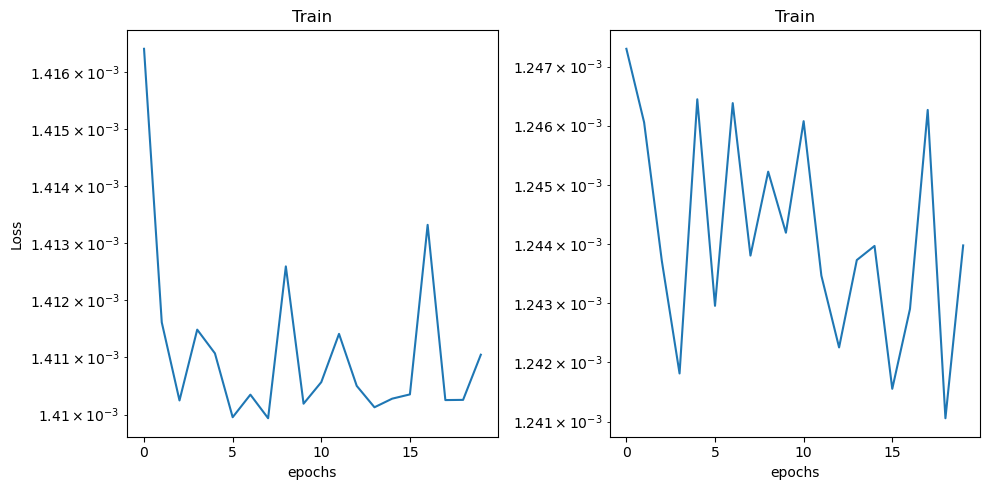

In [56]:
fig, ax = plt.subplots(1, 2, figsize=(2*5,5))
epochs_a = range(epochs)

ax[0].plot(epochs_a, train_loss_history)
ax[0].set_yscale("log")
ax[0].set_xlabel("epochs")
ax[0].set_ylabel("Loss")
ax[0].set_title("Train")
ax[1].plot(epochs_a, test_loss_history)
ax[1].set_yscale("log")
ax[1].set_xlabel("epochs")
ax[1].set_title("Train")
fig.tight_layout()